In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras import models, layers, activations
from keras.layers import Conv2D, TimeDistributed, BatchNormalization, MaxPooling2D, Flatten, Bidirectional, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping

In [2]:
x_data = np.load('face/face/face_x_data.npy') # x_save.npy
y_data = np.load('face/face/face_y_data.npy') # y_data.npy
y_data = keras.utils.to_categorical(y_data,11)
print(x_data.shape, y_data.shape)

(3000, 27, 64, 64, 3) (3000, 11)


In [3]:
# Train과 Test 분리
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size = 0.2, shuffle = True, stratify=y_data)
#X_train = X_train / 255
print("X_train: {}, X_test: {}".format(X_train.shape, X_test.shape))
print("Y_train: {}, Y_test: {}".format(Y_train.shape, Y_test.shape))

X_train: (2400, 27, 64, 64, 3), X_test: (600, 27, 64, 64, 3)
Y_train: (2400, 11), Y_test: (600, 11)


In [4]:
import efficientnet.keras as efn

class EfficientNet_LSTM(keras.Model):
    def __init__(self, num_classes):
        super(EfficientNet_LSTM, self).__init__()
        #self.BZ = input_shape[0]
        #self.frame = input_shape[1]
        self.EFNB0 = TimeDistributed(efn.EfficientNetB0(weights='imagenet', include_top=False,
                                               pooling='max'))
        self.EFNB0.trainable = False
        self.bilstm = layers.Bidirectional(layers.LSTM(128), merge_mode='concat')
        self.dense2 = layers.Dense(128, activation='relu')
        self.dense = layers.Dense(num_classes, activation='softmax')
        self.max_pool = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))
        self.dropout2 = layers.Dropout(0.2)
        self.dropout3 = layers.Dropout(0.3)
        self.flat = TimeDistributed(Flatten())

    def call(self, x):
        x = self.EFNB0(x)
        x = self.flat(x)
        x = self.dropout2(x)
        x = self.bilstm(x)
        #x = self.dense2(x)
        x = self.dropout2(x)
        return self.dense(x)

In [5]:
def get_model_vgg():
    return EfficientNet_LSTM(num_classes = 11)

In [6]:
model = get_model_vgg()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [7]:
es = EarlyStopping(monitor = 'val_loss', patience = 10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, verbose = 1, validation_split=0.2, callbacks = [es])

Epoch 1/100
60/60 [==============================] - 351s 5s/step - loss: 2.4371 - accuracy: 0.0964 - val_loss: 2.2776 - val_accuracy: 0.1312
Epoch 2/100
60/60 [==============================] - 295s 5s/step - loss: 2.2283 - accuracy: 0.1876 - val_loss: 2.2334 - val_accuracy: 0.1708
Epoch 3/100
60/60 [==============================] - 291s 5s/step - loss: 2.0920 - accuracy: 0.2411 - val_loss: 2.1098 - val_accuracy: 0.2396
Epoch 4/100
60/60 [==============================] - 288s 5s/step - loss: 1.9421 - accuracy: 0.3237 - val_loss: 2.0278 - val_accuracy: 0.2729
Epoch 5/100
60/60 [==============================] - 290s 5s/step - loss: 1.7981 - accuracy: 0.3797 - val_loss: 1.8716 - val_accuracy: 0.3562
Epoch 6/100
60/60 [==============================] - 290s 5s/step - loss: 1.5876 - accuracy: 0.4713 - val_loss: 1.7788 - val_accuracy: 0.3771
Epoch 7/100
60/60 [==============================] - 289s 5s/step - loss: 1.4654 - accuracy: 0.4973 - val_loss: 1.7169 - val_accuracy: 0.4083
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


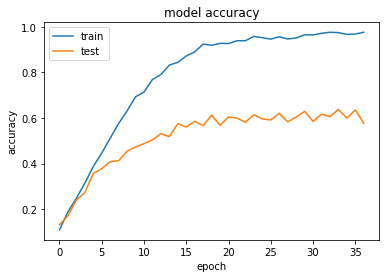

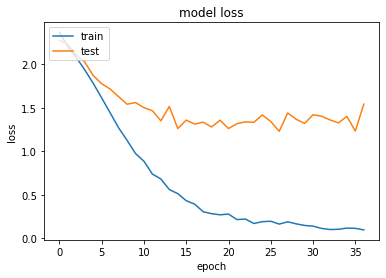

In [8]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
score = model.evaluate(X_test, Y_test, batch_size = 32, verbose = 1)
print("acc:", score[1], "loss:", score[0]) 

19/19 [==============================] - 91s 4s/step - loss: 1.5258 - accuracy: 0.6083
acc: 0.6083333492279053 loss: 1.525793194770813


In [15]:
from tensorflow.python.keras.models import load_model
model.save_weights('efficientnet_lstm_model.h5')